# Evaluation der Forumtracking-Trajektorienbündel


## 1. Preprocessing

In [1]:
#imports

import numpy as np
from scipy.optimize import least_squares, differential_evolution
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import RBF, Matern
import h5py

final_dataset = "forumtracking.hdf5"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)

origin = "4"

%run preprocessing.py
# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)

%run trajectory_simulation.py
# defines:
# def create_trajectories(mean, n_sample, len_sample, n_base, \
#                         len_base, base_type, var_base, \
#                         length_scale, total_scale, kind="RBF", \
#                         plot=False):

def adjust_length1d(line,length):
    t = np.arange(len(line))
    ti = np.linspace(t.min(), t.max(), length)
    fx = interp1d(t, line)
    xi = fx(ti)
    return xi

    

def get_xangle(u,deg=None):
    v = np.array([1,0])
    cosang = np.dot(u, v)
    sinang = np.linalg.norm(np.cross(u, v))
    if deg:
        return np.rad2deg(np.arctan2(sinang, cosang))
    else:
        return np.arctan2(sinang, cosang)

def rotate(points, theta):
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    return np.matmul(Phi, points.T).T

Phi = lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

/home/clemens/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1

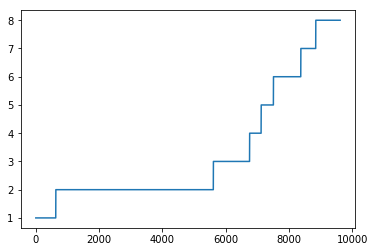

In [3]:
plt.plot(y_forum)
plt.show()

In [4]:
means = np.load("mean_per_bundle.npy")
stds = np.load("std_per_bundle.npy")

# Ziel 1

169.7003302393156


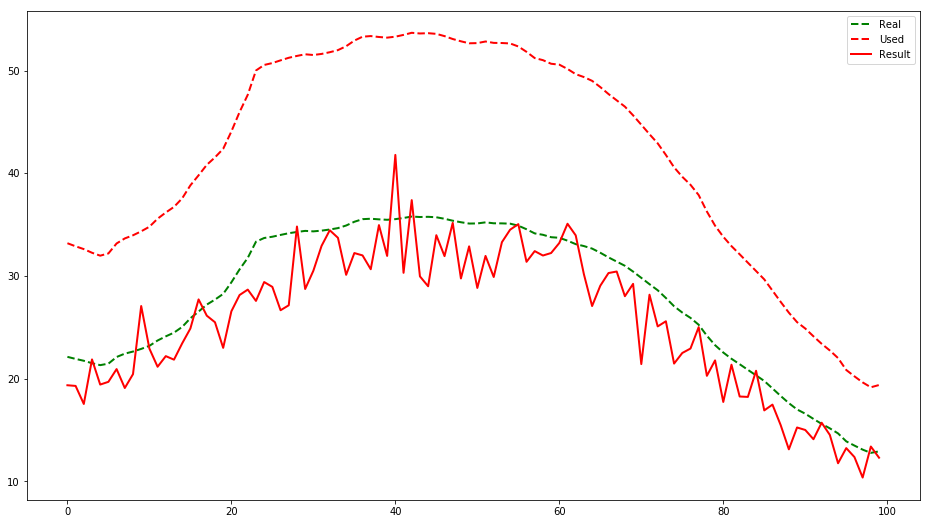

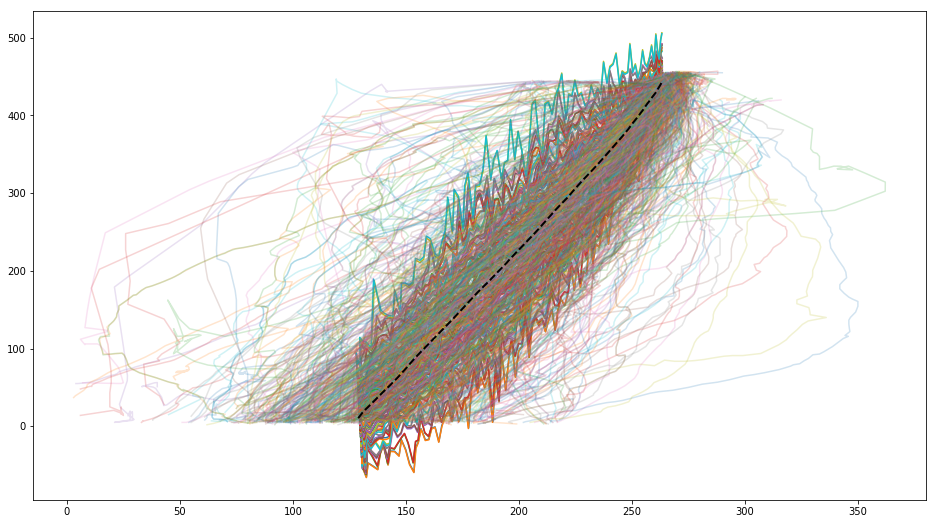

In [7]:
target = 1

data = X_forum[np.where(y_forum==target)]
mean = means[target-1]
#std = (20+20*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2))
std = stds[target-1]*1.5


n_total = 160
len_total = 100

n_base = 80
len_base = len(std)
std = adjust_length1d(std, len_base)

#var_base = 0.5*(20+100*np.exp(-1*np.linspace(-2,2,len_base)**2))
var_base = std
base_type = "normal"

length_scale = 20
total_scale = 1
cov_type = "RBF"

sim = create_trajectories(mean, n_total, len_total, n_base, len_base, base_type,\
                            var_base, length_scale, total_scale, cov_type, plot=False)

mean_free_sim = np.zeros((sim.shape[0],sim.shape[1]))

for i in range(sim.shape[0]):
    mean_free_sim[i] = np.linalg.norm(sim[i,:]-adjust_trajectory_length(mean,len_total),axis=1)

sim_std = np.std(mean_free_sim,axis=0)
print(np.linalg.norm(adjust_length1d(sim_std,len_base) - std))

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.plot(stds[target-1], linewidth=2, linestyle="--", c="g",label="Real")
ax1.plot(var_base, linewidth=2, linestyle="--",c="r",label="Used")
ax1.plot(sim_std, linewidth=2, c="r",label="Result")
ax1.legend()
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
for i in range(sim.shape[0]):
    ax1.plot(sim[i,:,0],sim[i,:,1])
for i in range(data.shape[0]):
    ax1.plot(data[i,:,0],data[i,:,1],alpha=0.2)
ax1.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
plt.show()

(80, 30, 2)


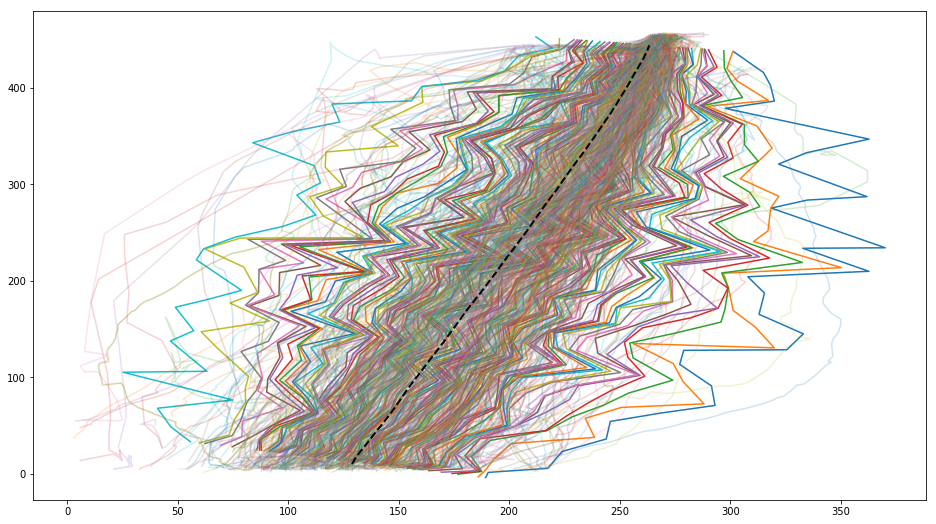

In [7]:
#adj_bases = adjust_base_length(bases, len_total, plot=True)
#samples = create_samples(n_total, len_total, length_scale, total_scale, kind, plot=True)
bases = create_bases(mean, n_base, len_base, var_base, base_type, plot=False)
print(bases.shape)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for b in bases:
    ax.plot(b[:,0],b[:,1])
for i in range(data.shape[0]):
    ax.plot(data[i,:,0],data[i,:,1],alpha=0.2)
ax.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
plt.show()

## Ziel 7

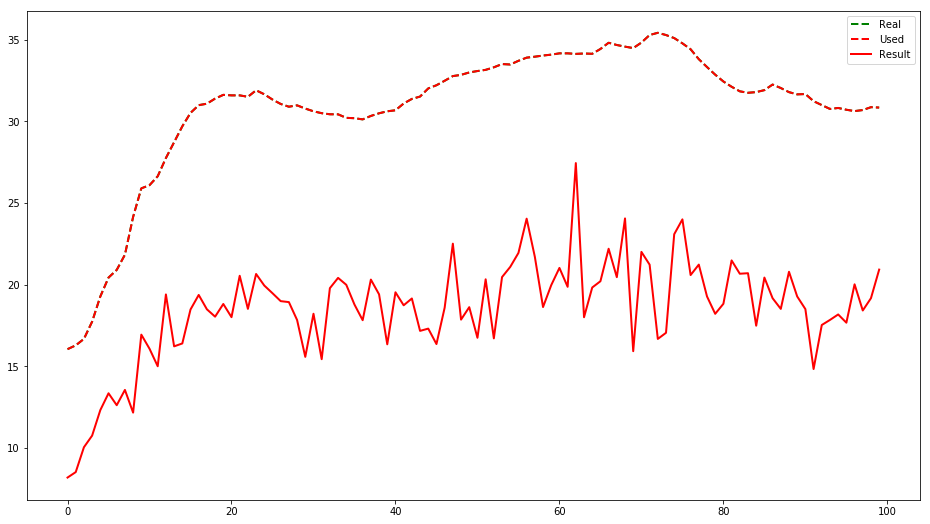

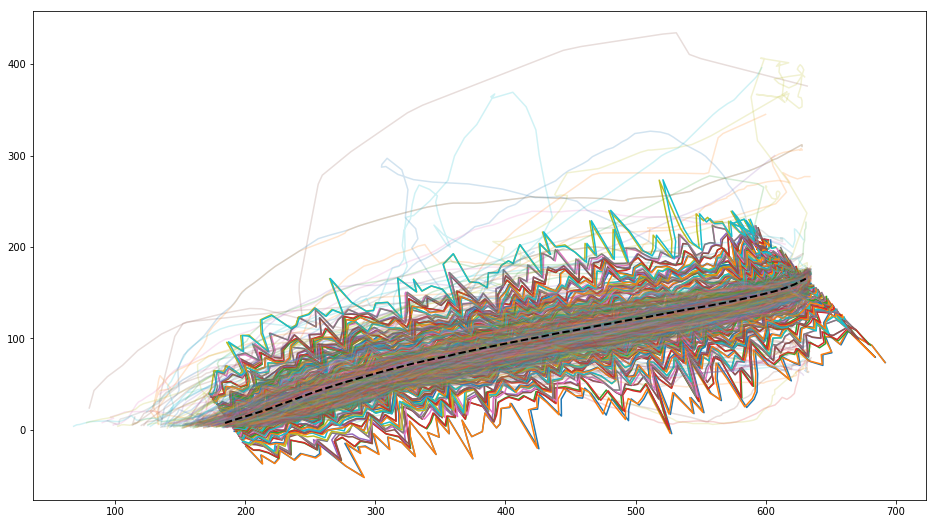

In [8]:
target = 7

data = X_forum[np.where(y_forum==target)]
mean = means[target-1]
#std = (20+20*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2))
std = stds[target-1]


n_total = 160
len_total = 100

n_base = 80
len_base = 100
std = adjust_length1d(std, len_base)

#var_base = 0.5*(20+100*np.exp(-1*np.linspace(-2,2,len_base)**2))
var_base = std
base_type = "normal"

length_scale = 20
total_scale = 1
cov_type = "Matern"

sim = create_trajectories(mean, n_total, len_total, n_base, len_base, base_type,\
                            var_base, length_scale, total_scale, cov_type, plot=False)

mean_free_sim = np.zeros((sim.shape[0],sim.shape[1]))

for i in range(sim.shape[0]):
    mean_free_sim[i] = np.linalg.norm(sim[i,:]-adjust_trajectory_length(mean,len_base),axis=1)

sim_std = np.std(mean_free_sim,axis=0)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.plot(stds[target-1], linewidth=2, linestyle="--", c="g",label="Real")
ax1.plot(var_base, linewidth=2, linestyle="--",c="r",label="Used")
ax1.plot(sim_std, linewidth=2, c="r",label="Result")
ax1.legend()
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
for i in range(sim.shape[0]):
    ax1.plot(sim[i,:,0],sim[i,:,1])
for i in range(data.shape[0]):
    ax1.plot(data[i,:,0],data[i,:,1],alpha=0.2)
ax1.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
plt.show()

## Ziel 8

In [11]:
target = 8

data = X_forum[np.where(y_forum==target)]
mean = means[target-1]
#std = (20+20*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2))
std = stds[target-1]*2


n_total = 160
len_total = 100

n_base = 80
len_base = 10
std = adjust_length1d(std, len_base)

#var_base = 0.5*(20+100*np.exp(-1*np.linspace(-2,2,len_base)**2))
var_base = std
base_type = "normal"

length_scale = 40
total_scale = 1
cov_type = "RBF"

sim = create_trajectories(mean, n_total, len_total, n_base, len_base, base_type,\
                            var_base, length_scale, total_scale, cov_type, plot=False)

mean_free_sim = np.zeros((sim.shape[0],sim.shape[1]))

for i in range(sim.shape[0]):
    mean_free_sim[i] = np.linalg.norm(sim[i,:]-adjust_trajectory_length(mean,len_base),axis=1)

sim_std = np.std(mean_free_sim,axis=0)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.plot(stds[target-1], linewidth=2, linestyle="--", c="g",label="Real")
ax1.plot(var_base, linewidth=2, linestyle="--",c="r",label="Used")
ax1.plot(sim_std, linewidth=2, c="r",label="Result")
ax1.legend()
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
for i in range(sim.shape[0]):
    ax1.plot(sim[i,:,0],sim[i,:,1])
for i in range(data.shape[0]):
    ax1.plot(data[i,:,0],data[i,:,1],alpha=0.2)
ax1.plot(mean[:,0],mean[:,1],linewidth=2,linestyle="--",c="k")
plt.show()

IndexError: index 11 is out of bounds for axis 0 with size 10

## Ziel 8 - Optimale Parameter


In [11]:
target = 7

data = X_forum[np.where(y_forum==target)]
mean = means[target-1]
#std = (20+20*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2))
std7 = stds[target-1]

#args = n_total, len_total, n_base, len_base, total_scale
bounds = [(10,1000),(50,300),(3,100),(10,500),(0.1,100)]

n_total = 160
len_total = 100

n_base = 80
len_base = 100

total_scale = 1


def target_fun(args):
    n_total = int(args[0])
    len_total = int(args[1])

    n_base = int(args[2])
    len_base = int(args[3])
    
    if n_total%n_base != 0:
        return np.inf
    
    std = adjust_length1d(std7, len_base)

    #var_base = 0.5*(20+100*np.exp(-1*np.linspace(-2,2,len_base)**2))
    var_base = std
    base_type = "normal"

    length_scale = 20
    total_scale = int(args[4])
    cov_type = "Matern"
    sim = create_trajectories(mean, n_total, len_total, n_base, len_base, base_type,\
                                var_base, length_scale, total_scale, cov_type, plot=False)
    mean_free_sim = np.zeros((sim.shape[0],sim.shape[1]))

    for i in range(sim.shape[0]):
        mean_free_sim[i] = np.linalg.norm(sim[i,:]-adjust_trajectory_length(mean,len_total),axis=1)

    sim_std = np.std(mean_free_sim,axis=0)
    return np.linalg.norm(adjust_length1d(sim_std,len_base) - std)

result = differential_evolution(target_fun, bounds)
print(result.x)

/home/clemens/.anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[910.08924556  61.766489    14.3533818   10.22597368  46.11645822]
